# 05 — Emotion Detection Modeling

## Objectives
- Mendeteksi emosi dominan dalam ulasan pengguna
- Menghasilkan fitur emosi untuk analisis klaster
- Memahami pola emosi lintas aplikasi e-wallet

## Input
- data/processed/sentiment_e_wallet_reviews.csv

## Output
- Dataset dengan emotion_label dan emotion_score

GOOGLE DRIVE MOUNT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


IMPORT LIBRARIES

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from transformers import pipeline

PATH CONFIGURATION & LOAD DATA

In [3]:
BASE_PATH = "/content/drive/MyDrive/ewallet_nlp_clustering_project"
PROCESSED_DATA_PATH = f"{BASE_PATH}/data/processed"
OUTPUT_PATH = f"{BASE_PATH}/outputs"

INPUT_FILE = f"{PROCESSED_DATA_PATH}/sentiment_e_wallet_reviews.csv"

df = pd.read_csv(INPUT_FILE)
print(f"Loaded {len(df)} reviews")

Loaded 11141 reviews


## Emotion Detection Strategy

Approach:
- Transformer-based emotion classification
- Multi-class emotion labeling

Emotion categories:
- anger
- fear
- joy
- sadness
- surprise
- neutral

Rationale:
Emotion provides richer psychological signals than polarity-based sentiment,
especially for user behavior segmentation.


LOAD EMOTION CLASSIFICATION MODEL

In [4]:
emotion_pipeline = pipeline(
    task="text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    top_k=None,
    device=0 if torch.cuda.is_available() else -1
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0


EMOTION PREDICTION FUNCTION

In [5]:
EMOTION_LABELS = ["anger", "fear", "joy", "sadness", "surprise", "neutral"]

def predict_emotions(texts, batch_size=16):
    dominant_emotions = []
    emotion_scores = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size].tolist()
        results = emotion_pipeline(batch)

        for res in results:
            res_sorted = sorted(res, key=lambda x: x["score"], reverse=True)
            dominant_emotions.append(res_sorted[0]["label"])
            emotion_scores.append(res_sorted[0]["score"])

    return dominant_emotions, emotion_scores

RUN EMOTION DETECTION

In [6]:
emotion_labels, emotion_scores = predict_emotions(df["clean_text"])

df["emotion_label"] = emotion_labels
df["emotion_score"] = emotion_scores


  1%|▏         | 9/697 [00:01<01:21,  8.48it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset

100%|██████████| 697/697 [01:17<00:00,  9.05it/s]


EMOTION DISTRIBUTION ANALYSIS

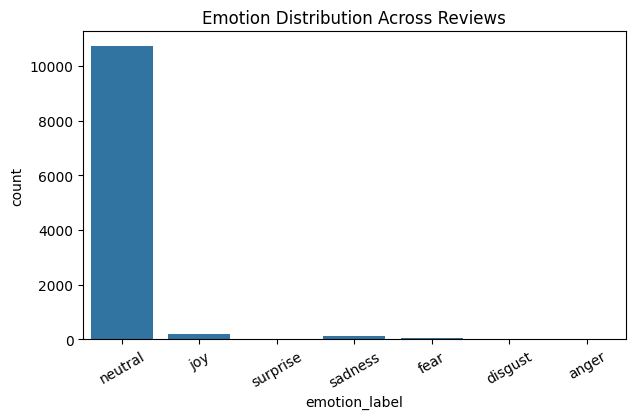

In [7]:
plt.figure(figsize=(7,4))
sns.countplot(x="emotion_label", data=df)
plt.title("Emotion Distribution Across Reviews")
plt.xticks(rotation=30)
plt.show()

EMOTION DISTRIBUTION BY APPLICATION

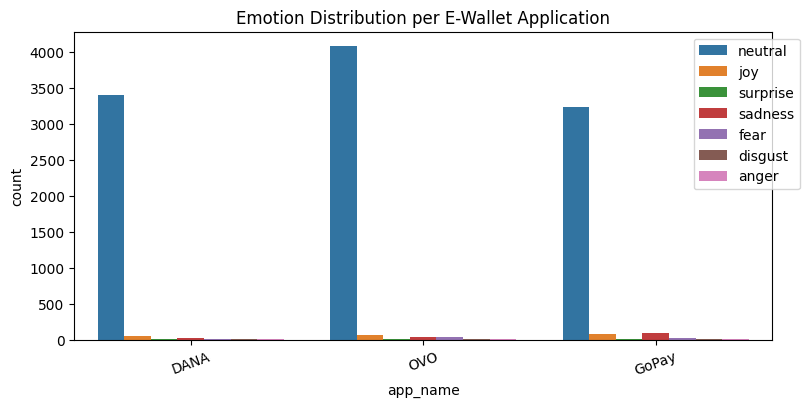

In [8]:
plt.figure(figsize=(9,4))
sns.countplot(data=df, x="app_name", hue="emotion_label")
plt.title("Emotion Distribution per E-Wallet Application")
plt.xticks(rotation=20)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

EMOTION CONFIDENCE ANALYSIS

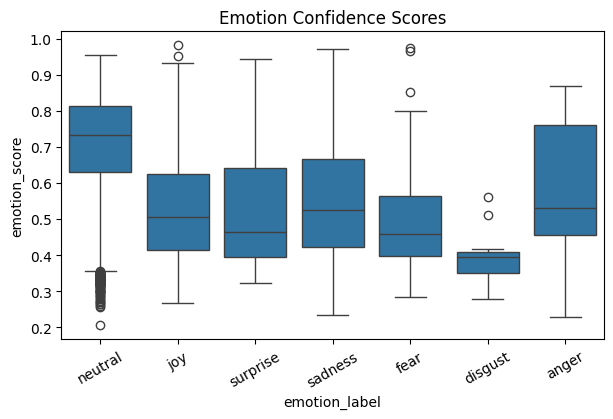

In [9]:
plt.figure(figsize=(7,4))
sns.boxplot(x="emotion_label", y="emotion_score", data=df)
plt.title("Emotion Confidence Scores")
plt.xticks(rotation=30)
plt.show()

EMOTION vs SENTIMENT RELATIONSHIP

In [10]:
pd.crosstab(
    df["sentiment_label"],
    df["emotion_label"],
    normalize="index"
)

emotion_label,anger,disgust,fear,joy,neutral,sadness,surprise
sentiment_label,,,,,,,
negative,0.001339,0.000000,0.004781,0.018742,0.955632,0.017977,0.001530
neutral,0.000604,0.000000,0.005440,0.009973,0.972197,0.010879,0.000907
positive,0.001153,0.005763,0.003458,0.018824,0.963504,0.004226,0.003073


EMOTION VECTOR REPRESENTATION

In [11]:
emotion_dummies = pd.get_dummies(df["emotion_label"], prefix="emotion")
df = pd.concat([df, emotion_dummies], axis=1)

SAVE DATASET WITH EMOTION FEATURES

In [12]:
OUTPUT_FILE = f"{PROCESSED_DATA_PATH}/emotion_e_wallet_reviews.csv"

df.to_csv(OUTPUT_FILE, index=False)

print(f"Emotion-enhanced dataset saved:\n{OUTPUT_FILE}")

Emotion-enhanced dataset saved:
/content/drive/MyDrive/ewallet_nlp_clustering_project/data/processed/emotion_e_wallet_reviews.csv


## Emotion Detection Summary

✔ Multi-class emotion classification applied  
✔ Dominant emotion extracted per review  
✔ Emotion vectors constructed  
✔ Emotion features prepared for clustering  

Conclusion:
Emotion-aware modeling captures psychological nuances of user feedback
that cannot be represented by sentiment polarity alone.
